# A Brief Data Processing Example

#### Paul Britton
#### 2021-08-08

Following is a brief data processing example using data from the Egg Farmers of Canada website.  

## Load the required libraries and Download some Data


In [1]:
import requests
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from pandas.tseries.offsets import *

Below we download data from the Tableau view available on the [Egg Farmers Of Canada](https://www.eggfarmers.ca/market-information-tables/#tableau-1) website.  Note that the link needs to be manually supplied below via cut & paste as Tableau does not appear to allow easy programatic access to this data. 

I've commented out the section below as it was only used to collect a copy of the data, which in the interest of reproducibility, is now stored on github.

In [2]:

#cut and pasted from the egg farmers website - this was captured @ 12:20 PM, 2021-08-08
'''
url = "https://public.tableau.com/vizql/w/ESPMarketInformationDataExternalv2/v/EFCCOP-POCCDP/vudcsv/sessions/45A81A5C08F745A8A4F2B1F41A5B8D6D-0:0/views/7713620505763405234_17615979376152457797?showall=true&underlying_table_id=Migrated Data&underlying_table_caption=Full Data"

#get the url
data = requests.get(url)

#dump the data to a file which we'll put on github
outputFileName = 'eggs_cop.csv'
with open(outputFileName, 'wb') as f:
    f.write(data.content)
'''


'\nurl = "https://public.tableau.com/vizql/w/ESPMarketInformationDataExternalv2/v/EFCCOP-POCCDP/vudcsv/sessions/45A81A5C08F745A8A4F2B1F41A5B8D6D-0:0/views/7713620505763405234_17615979376152457797?showall=true&underlying_table_id=Migrated Data&underlying_table_caption=Full Data"\n\n#get the url\ndata = requests.get(url)\n\n#dump the data to a file which we\'ll put on github\noutputFileName = \'eggs_cop.csv\'\nwith open(outputFileName, \'wb\') as f:\n    f.write(data.content)\n'

## Load the Data

Next we load the data into a dataframe and inspect it.  From the below, we can see that we have approximately 161K timeseries records including thing like geography, grade, and cost of production. 

In [3]:
#load the captured data 
df = pd.read_csv('https://raw.githubusercontent.com/brivaResearch/eggData/main/eggs_cop.csv')

#and inspect
df.info()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161161 entries, 0 to 161160
Data columns (total 11 columns):
Week/ Semaine            161161 non-null int64
Provinces                161161 non-null object
Grade/Catégorie          161161 non-null object
Week                     161161 non-null int64
Year                     161161 non-null int64
CognosWeekNo             161161 non-null int64
Grade/CategorieSource    161161 non-null object
ProvincefromDB           161161 non-null object
COP Prices               161161 non-null float64
Measure Values           161161 non-null float64
Number of Records        161161 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 13.5+ MB


,Week/ Semaine,Provinces,Grade/Catégorie,Week,Year,CognosWeekNo,Grade/CategorieSource,ProvincefromDB,COP Prices,Measure Values,Number of Records
0,201439,PE,XL,39,2014,201439,J,PE,0.0,0.0,1
1,201440,PE,XL,40,2014,201440,J,PE,0.0,0.0,1
2,201441,PE,XL,41,2014,201441,J,PE,0.0,0.0,1
3,201442,PE,XL,42,2014,201442,J,PE,0.0,0.0,1


## Format the Data

Note that the dates included in this data contain a year, month and a 'week of year' rather than a more standard YYYYMM or YYYYMMDD type format.  It's not really a problem, but for the purposes of plotting, we will convert the "Year + weeknum" to a date-index with the format YYYY-MM-DD.  The original data-source states that the prices are valid as of the Sunday of the price week, so for our purposes here, we'll assume that Sunday denotes the beginning of the week and then synch our custom datestamps to Mondays.  We use Monday rather than Sunday as the former is a business day, thus making synchronization with subsequent commodity price data considerably easier.   

We also set up our dataframe as multi-indexed so that we can easily isolate timeseries by geography and grade.

In [4]:
#convert the "week of year" col to an actual datestamp  
df['dateIndex'] = pd.to_datetime(df.Year.astype(str), format='%Y') + pd.to_timedelta(df.Week.mul(7).astype(str) + ' days')+ Week(weekday=0)

#set multi-index and sort
df = df.set_index(['Provinces','Grade/Catégorie','dateIndex'])
df.sort_index(inplace=True)


## Subset for Ontario

We'll focus exclusively on the cost of production for "Large" eggs from "Ontario", a subset which was chosen arbitrarily.

We can see in the plot below that the cost of production has risen from < 20 to > 35 since the year 2000 - an increase of 89%.  

The cost of production has increased 88.98% over this period


Text(0, 0.5, 'Cost')

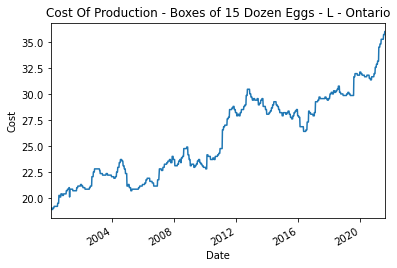

In [5]:
#get just ONT, L
ontEggs = df.loc['ON','L']['COP Prices']


#print % change
print("The cost of production has increased {:.2%} over this period".format( ontEggs.iloc[-1] / ontEggs.iloc[0] - 1))

#Plot 
ontEggs.plot(title='Cost Of Production - Boxes of 15 Dozen Eggs - L - Ontario')
plt.xlabel('Date')
plt.ylabel('Cost')



## Collect Commodity Price Data

Next we collect price data for various commodities which could plausibly be used as chicken feed given that feed is likely a key input into the cost of production.  We'll gather data for the soy complex, corn and wheat.

A quick visual inspection via the plots below shows that, while the scale of these markets is different, the data otherwise looks okay.

[*********************100%***********************]  5 of 5 completed


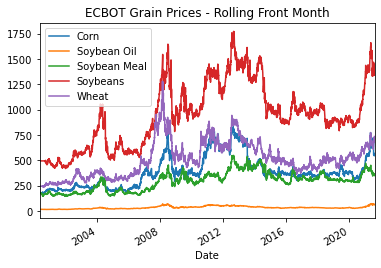

In [6]:
#collect grains data from yahoo finance
grains = yf.download(["ZS=F","ZL=F","ZM=F","ZC=F","ZW=F"], start="2000-05-16", end=ontEggs.index[-1].date())

#use only closing prices
grains = grains.Close

#give them human readable names
grains.rename({"ZS=F":"Soybeans",
                "ZL=F":"Soybean Oil",
                "ZM=F":"Soybean Meal",
                "ZC=F":"Corn",
                "ZW=F":"Wheat"},
                axis='columns',
                inplace=True)

#forward first to close any gaps in a causal way
grains.fillna(method = 'ffill',inplace=True)

#backfill to make sure series dont have leading Nans
grains.fillna(method = 'bfill',inplace=True)

#check visually
grains.plot(title="ECBOT Grain Prices - Rolling Front Month")



## Process and Merge

Now we merge the Cost of Production data for the Ontario Large eggs with the commodity data - none of the commodities trade on the weekend, which is why, when modifying the egg-data timestamps, we chose to use a Monday timestamp - as such, we'll be synchronizing with the commodity data using a Monday reference point. 

We also index all the data to a starting value of 1, for easier cross-sectional comparison.

We can see below commodities have been considerably more volatile than the cost of egg production since 2001.  Beyond this superficial observation, is there any meaningful / usable relationship contained within this data?

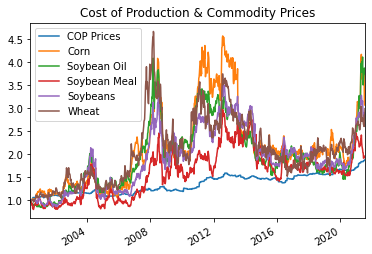

In [7]:
data = pd.merge(ontEggs,grains,left_index=True,right_index=True)
data.divide(data.iloc[0]).plot(title = "Cost of Production & Commodity Prices")


## Looking for a Relationship

We want to see if there's any relationship between commodity prices and the cost of production for eggs.  To do this, we'll look at the correlation of the various commodity prices to the cost of production.  Also, it stands to reason that there might be a lead/lag relationship present in these data and as such, we'll explore a space that spans a range of lagged correlation and leading correlations covering the space of +/- 20 weeks.


In [8]:
#create stationary price deltas for correlation
delta = (data.divide(data.shift(1))-1).dropna()


In [9]:
#loop over the range -20 to +20, computing and storing correlation vs COP at each step
r = {}
for i in range(-20,20):
    d = delta.copy()
    d.iloc[:,1:] = d.iloc[:,1:].shift(i)
    d.dropna()
    r[i] = d.corr().iloc[1:,0].values

## Collate and Visualize Results

We collect the data into a dataframe, rename the columns for more intuitive presentation and create a few plots

Text(0, 0.5, 'Correlation Coefficient')

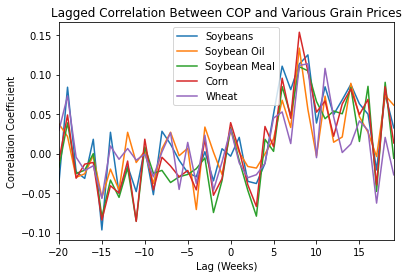

In [10]:
#load the correlation data to a df
corrDf = pd.DataFrame(r).T

#add human readable names
corrDf.rename({0:"Soybeans",
                1:"Soybean Oil",
                2:"Soybean Meal",
                3:"Corn",
                4:"Wheat"},
                axis='columns',
                inplace=True)


#plot
corrDf.plot(legend=True,
            title='Lagged Correlation Between COP and Various Grain Prices')

plt.xlabel('Lag (Weeks)')
plt.ylabel('Correlation Coefficient')


Text(0, 0.5, 'Lagged R^2 Between COP and Various Grain Prices ')

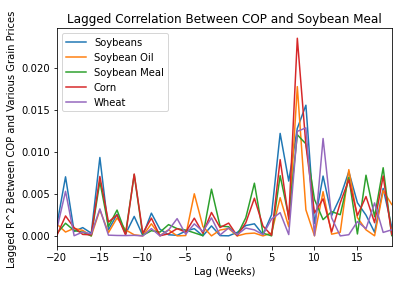

In [11]:

(corrDf**2).plot(legend=True,
            title='Lagged Correlation Between COP and Soybean Meal')

plt.xlabel('Lag (Weeks)')
plt.ylabel('Lagged R^2 Between COP and Various Grain Prices ')

## Results

The above seem to indicate that there is no substantial correlation between the price of various agricultural commodities and the cost of egg production, at least in the short term (20 weeks either side of the egg/cost-of-production datapoint)

We do see a somewhat surprising output that there is a slight historical relationship between grain prices and the cost of producing eggs whereby the cost of egg production appears to be a leading indicator of various grain prices.  While this is likely spurious and almost certainly non-causal, it tells us that, at least historically, there has been a tendency that if COP rises today, grain prices can be expected to rise slightly in 5-20 weeks.

With an R-Squared of only 2%, meaning that 2% of the variability in egg-production costs is explained by grain prices, the effect is by no means large.